In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
import glob
import numpy as np
import pandas as pd 
import nibabel as nib
from nilearn.input_data import NiftiMasker
from matplotlib import pyplot as plt
import seaborn as sns

from himalaya.scoring import correlation_score
from scipy import sparse
from neuromaps.transforms import fsaverage_to_fsaverage

sys.path.append('../utils/') 

from config import *
import dataset_utils as utils
from tommy_utils import statistics, plotting, encoding, nlp

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Select a current dataset to analyze

In [3]:
dataset = 'huth-moth'
model_name = 'gpt2-xl'
task = 'wheretheressmoke' # only evaluate for one test task for now

results_dir = os.path.join(BASE_DIR, 'derivatives/results/', dataset) #, p.sub, p.model_name)
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/encoding_preds/', dataset, 'group')

utils.attempt_makedirs(plots_dir)

if dataset == 'deniz-readinglistening':
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc/')
else:
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc-smooth/')
    masks_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/masks/group/')
    mask_fn = os.path.join(masks_dir, 'group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
    masker = NiftiMasker(mask_fn).fit()

## Create label flip null-distribution

For each contrast type:
1. Load all subjects data
2. Randomly flip a subset of labels
3. Calculate MSE for each voxel

In [4]:
# get subjects excluding their html files
sub_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub*[!html]')))
sub_list = [os.path.basename(d) for d in sub_dirs]

In [5]:
# load gentle trasncript
gentle_dir = os.path.join(DATASETS_DIR, dataset, 'stimuli', 'gentle', task)
transcript_fn = os.path.join(gentle_dir, 'align.json')

df_transcript = encoding.load_gentle_transcript(
    transcript_fn=transcript_fn, 
    start_offset=None #stim_times[0] if stim_times else None
)

## MAKE ADJUSTMENTS TO MODEL FEATURES FROM BEHAVIOR ########
behavior_results_fn = os.path.join(BASE_DIR, f'derivatives/results/behavioral/task-{task}_group-analyzed-behavior_human-model-lemmatized.csv')
behavior_results = pd.read_csv(behavior_results_fn)

crit_idxs = np.unique(behavior_results['word_index'])

# get critical word trs
critical_word_trs = df_transcript.loc[crit_idxs, ['start', 'end']] // 2
critical_word_trs = critical_word_trs['end'].astype(int).to_numpy()
print (f'Total trs: {len(critical_word_trs)}')

# reduce to unique critical words
critical_word_trs = np.unique(critical_word_trs)
print (f'Unique trs: {len(critical_word_trs)}')

Total trs: 237
Unique trs: 195


In [6]:
def load_data(sub_list, data_dir, results_dir, model_name, task, session='', dtype='ground-truth'):
    """
    Load data for a given datatype across all subjects.
    
    Parameters:
    - sub_list: list of subject IDs
    - data_dir: directory containing subject data
    - results_dir: directory containing model results
    - task: task name
    - session: session identifier
    - datatype: type of data to load ('model-predicted', 'human-audio', or 'human-text')
    
    Returns:
    - numpy array of shape (num_subjects, ...) containing the loaded data
    """
    
    all_subject_data = []
    
    for sub in sub_list:
        if dtype == 'ground-truth': 
            file_pattern = os.path.join(data_dir, sub, f'*{session}*{task}*hyperaligned.npy')
        else:
            file_pattern = os.path.join(results_dir, sub, model_name, f'*{session}*{task}*prediction*{dtype}*.npy')

        data_files = sorted(glob.glob(file_pattern))
        
        if task == 'wheretheressmoke':
            assert len(data_files) in [2, 5], f"Unexpected number of files for subject {sub}"
        else:
            assert len(data_files) == 1, f"Unexpected number of files for subject {sub}"

        print (f'{sub} – loading {len(data_files)} files')
        subject_data = np.mean([np.load(f) for f in data_files], axis=0)
        all_subject_data.append(subject_data)
    
    return np.stack(all_subject_data)

def calculate_mse(Y_true, Y_pred, crit_trs, axis=-1):

    # absolute_error = abs(Y_true - Y_pred).take(crit_trs, axis=axis)

    mse = (Y_true - Y_pred)**2
    mse = mse.take(crit_trs, axis=axis)
    
    return mse

def conduct_mse_contrast(dss, crit_trs, axis=-1):

    contrast_dtypes = set(dss.keys()).difference(['ground-truth'])

    dss_contrast = {}

    for dtype in contrast_dtypes:
        dss_contrast[dtype] = calculate_mse(dss[dtype], dss['ground-truth'], crit_trs, axis=1)

    return dss_contrast

In [7]:
dtypes = ['ground-truth', 'model-predicted', 'human-audio', 'human-text']

# load all datatypes 
dss = {dtype: load_data(sub_list, data_dir, results_dir, model_name=model_name, task=task, dtype=dtype) for dtype in dtypes}

# conduct contrast between each dtype and ground truth
dss_contrast = conduct_mse_contrast(dss, critical_word_trs, axis=1)

sub-UTS01 – loading 5 files
sub-UTS02 – loading 5 files
sub-UTS03 – loading 5 files
sub-UTS04 – loading 5 files
sub-UTS05 – loading 5 files
sub-UTS06 – loading 5 files
sub-UTS07 – loading 5 files
sub-UTS08 – loading 5 files
sub-UTS01 – loading 5 files
sub-UTS02 – loading 5 files
sub-UTS03 – loading 5 files
sub-UTS04 – loading 5 files
sub-UTS05 – loading 5 files
sub-UTS06 – loading 5 files
sub-UTS07 – loading 5 files
sub-UTS08 – loading 5 files
sub-UTS01 – loading 5 files
sub-UTS02 – loading 5 files
sub-UTS03 – loading 5 files
sub-UTS04 – loading 5 files
sub-UTS05 – loading 5 files
sub-UTS06 – loading 5 files
sub-UTS07 – loading 5 files
sub-UTS08 – loading 5 files
sub-UTS01 – loading 5 files
sub-UTS02 – loading 5 files
sub-UTS03 – loading 5 files
sub-UTS04 – loading 5 files
sub-UTS05 – loading 5 files
sub-UTS06 – loading 5 files
sub-UTS07 – loading 5 files
sub-UTS08 – loading 5 files


### We have loaded all data --> conduct a given contrast

In [9]:
feature_contrasts = [
    ['model-predicted', 'human-audio'],
    ['model-predicted', 'human-text'],
    # ['model-predicted', 'ground-truth'],
    # ['human-audio', 'ground-truth'],
    # ['human-text', 'ground-truth'],
    ['human-audio', 'human-text'] 
]

In [144]:
def make_random_indices(n_items, n_perms, method='choice', max_random_seed=2**32-1):
    
    random_state = None
    random_idxs = []
    
    for i in range(n_perms):
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)
    
        # get the permuted indices
        if method == 'permutation':
            perm_idxs = prng.permutation(n_items)
        elif method == 'choice':
            perm_idxs = prng.choice(np.arange(n_items), replace=True)
        elif method == 'swap':
            perm_idxs = [np.empty(0, dtype=int)] + list(utils.all_combinations(np.arange(n_items)))
            perm_idxs = np.array(prng.choice(perm_idxs, replace=True))
        else:
            print ('Permutation methods are choice and permutation')
            sys.exit(0)
    
        random_idxs.append(perm_idxs)
    
        #randomly select another random_state for next time
        random_state = np.random.RandomState(prng.randint(0, max_random_seed))
        
    return random_idxs

def label_permutation_test(true, pred, metric, n_perms=1000):
    
    n_items = int(true.shape[0])
    perm_idxs = make_random_indices(n_items=n_items, n_perms=n_perms, method='swap')

    permutations = []
    
    for i, perm in enumerate(perm_idxs):
        # create copies of arrays to prevent altering original
        _true, _pred = true.copy(), pred.copy()
    
        # Swap the selected items
        _true[perm], _pred[perm] = pred[perm], true[perm]
    
        # compute the metric
        result = metric(_true, _pred)
        
        permutations.append(result)
    
        print (f'Finished {i+1}/{n_perms}', flush=True)
    
    permutations = np.stack(permutations)
    
    return permutations


def bootstrap_test(data, metric, n_iters=1000, alpha=0.05):
    """
    Perform bootstrap resampling to test if Group A - Group B is significantly above chance.
    
    Parameters:
    # data (numpy.ndarray): Array of shape (n_subjects, 2) where column 0 is Group A and column 1 is Group B
    n_iterations (int): Number of bootstrap iterations
    alpha (float): Significance level
    
    Returns:
    tuple: (is_significant, p_value, confidence_interval)
    """
    
    n_items = data.shape[0]
    # observed_diff = np.mean(data[:, 0] - data[:, 1])
    
    bootstraps = []
    
    for i in range(n_iters):
        # Resample with replacement
        resampled_data = data[np.random.choice(n_items, size=n_items, replace=True)]
        result = metric(resampled_data)

        bootstraps.append(result)
        print (f'Finished {i+1}/{n_iters}', flush=True)
        
    #     bootstrap_diffs[i] = np.mean(resampled_data[:, 0] - resampled_data[:, 1])
    
    # # Calculate p-value
    # p_value = np.mean(bootstrap_diffs <= 0)
    
    # # Calculate confidence interval
    # confidence_interval = np.percentile(bootstrap_diffs, [alpha/2 * 100, (1 - alpha/2) * 100])
    
    # # Check if the difference is significantly above chance
    # is_significant = p_value < alpha
    bootstraps = np.stack(bootstraps)
    
    return bootstraps #is_significant, p_value, confidence_interval


In [106]:
# select a given contrast --> get data for each 
contrast = feature_contrasts[-1]
dss_a, dss_b = [dss_contrast[feature] for feature in contrast]

In [145]:
# returns a n_perms x n_subs x n_trs x n_voxels
metric = lambda x, y: (x-y).mean(0).mean(0)
perms = label_permutation_test(dss_a, dss_b, metric, n_perms=10000)

/scratch/ipykernel_44846/281689846.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  perm_idxs = np.array(prng.choice(perm_idxs, replace=True))


Finished 1/10000
Finished 2/10000
Finished 3/10000
Finished 4/10000
Finished 5/10000
Finished 6/10000
Finished 7/10000
Finished 8/10000
Finished 9/10000
Finished 10/10000
Finished 11/10000
Finished 12/10000
Finished 13/10000
Finished 14/10000
Finished 15/10000
Finished 16/10000
Finished 17/10000
Finished 18/10000
Finished 19/10000
Finished 20/10000
Finished 21/10000
Finished 22/10000
Finished 23/10000
Finished 24/10000
Finished 25/10000
Finished 26/10000
Finished 27/10000
Finished 28/10000
Finished 29/10000
Finished 30/10000
Finished 31/10000
Finished 32/10000
Finished 33/10000
Finished 34/10000
Finished 35/10000
Finished 36/10000
Finished 37/10000
Finished 38/10000
Finished 39/10000
Finished 40/10000
Finished 41/10000
Finished 42/10000
Finished 43/10000
Finished 44/10000
Finished 45/10000
Finished 46/10000
Finished 47/10000
Finished 48/10000
Finished 49/10000
Finished 50/10000
Finished 51/10000
Finished 52/10000
Finished 53/10000
Finished 54/10000
Finished 55/10000
Finished 56/10000
F

<Axes: ylabel='Count'>

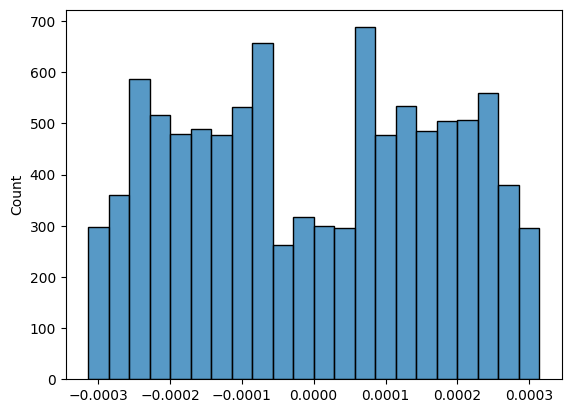

In [180]:
sns.histplot(perms[:, 20000])

In [170]:
np.argmin(gt_contrast)

1780

In [177]:
gt_contrast[50000]

0.0005496334

In [176]:
pvals[50000]

0.23587641235876414

In [146]:
gt_contrast = (dss_a - dss_b).mean(0).mean(0)

zvals, pvals = statistics.p_from_null(gt_contrast, perms, axis=0)

gt_contrast[np.argwhere(pvals >= 0.05)] = np.nan

In [151]:
np.argwhere(pvals < 0.01)

(892, 1)

Here


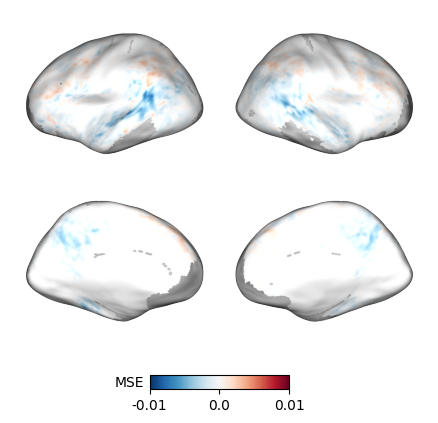

In [130]:
ds = gt_contrast
cmap = 'RdBu_r'

vmax = np.nanmax(abs(ds))

# out_fn = os.path.join(plots_dir, f'group_listening-reading-contrast_all-tasks_loo-isc.{EXT}')

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(ds, target_density='41k')
else:
    ds = masker.inverse_transform(ds)
    surfs, data = plotting.vol_to_surf(ds, surf_type='fsaverage', map_type='inflated')

layer = plotting.make_layers_dict(data=data, cmap=cmap, label='MSE', alpha=1, color_range=(-vmax, vmax))

_ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, embed_nb=True)

In [121]:
plotting.plot_surf_data?

Signature:
plotting.plot_surf_data(
    surfs,
    layers_info,
    surf_type='fslr',
    views=['lateral', 'medial'],
    zoom=1.35,
    brightness=0.8,
    scale=(10, 10),
    surf_alpha=1,
    add_depth=False,
    embed_nb=False,
    colorbar=True,
    cbar_loc=None,
    title=None,
    out_fn=None,
)
Docstring: <no docstring>
File:      /dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/tommy_utils/plotting.py
Type:      function

In [323]:
np.abs(gt_contrast - np.mean(bootstraps))

array([0.00155985, 0.00160296, 0.0029413 , ..., 0.00093988, 0.00037644,
       0.00029421], dtype=float32)

In [316]:
p_value

0.5872374059061957

In [264]:
dss_a.shape

(8, 195, 56991)

In [262]:
gt_contrast

array([ 0.00440085,  0.0045743 ,  0.00433536, ...,  0.00475394,
       -0.00010032,  0.00054709], dtype=float32)

In [178]:
gt_contrast[100]

-0.00058308925

<Axes: ylabel='Count'>

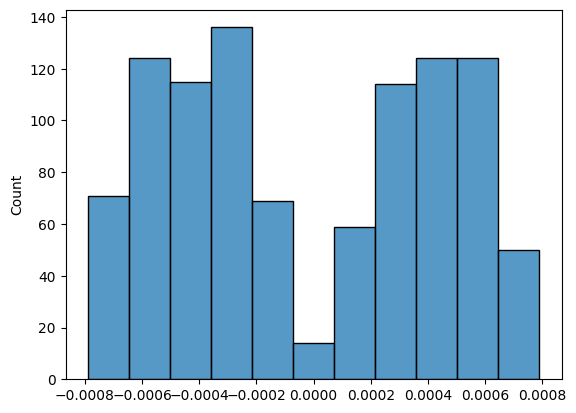

In [20]:
sns.histplot(perms[:, 50000])

In [12]:
perms = np.nanmean(np.nanmean(perms, axis=1), axis=1)


KeyboardInterrupt



In [ ]:
perms[:, 10000]

In [101]:
all_swap_lens = []

for i in make_random_indices(n_items=8, n_perms=1000, method='swap'):
    all_swap_lens.append(len(i))

In [ ]:
feature_contrasts = [
    ['model-predicted', 'human-audio'],
    ['model-predicted', 'human-text'],
    # ['model-predicted', 'ground-truth'],
    # ['human-audio', 'ground-truth'],
    # ['human-text', 'ground-truth'],
    ['human-audio', 'human-text'] 
]

behavioral_feature_types = ['model-predicted', 'human-audio', 'human-text'] #'ground-truth', 

# initialize dictionary of contrasts
all_contrasts = {' - '.join(contrast): [] for contrast in feature_contrasts}

all_sub_residuals = {dtype: [] for dtype in behavioral_feature_types}

for sub, pvals in zip(sub_list, sub_pvals):
    
    sub_results_dir = os.path.join(results_dir, sub, model_name)
    sub_data_dir = os.path.join(data_dir, sub)
    
    ds_sub_residuals = {} 

    for behavioral_type in behavioral_feature_types:

        if dataset == 'deniz-readinglistening':
            # sub_mapper_fn = glob.glob(os.path.join(data_dir, sub, 'mappers', '*fsaverage*'))
            
            # assert (len(sub_mapper_fn) == 1)
    
            # mapper = sparse.load_npz(sub_mapper_fn[0])
    
            if session:
                sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{session}*{task}*hyperaligned.npy')))
                sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{session}*{task}*prediction*{behavioral_type}*.npy')))
            else:
                sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
                sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*{behavioral_type}*.npy')))    
        else:
            
            sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
            sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*{behavioral_type}*.npy')))
    
         # load ground-truth predictions --> predictions are the same regardless of run since weights dont change
        assert ((len(sub_data_fn) == 5 or len(sub_data_fn) == 2))
    
        # load results, average and correlate with ground truth
        Y_true = np.mean([np.load(fn) for fn in sub_data_fn], axis=0)
        Y_pred = np.mean([np.load(fn) for fn in sub_results_fn], axis=0)
    
        absolute_error, mse = calculate_error(Y_true, Y_pred, critical_word_trs)
        ds_sub_residuals[behavioral_type] = mse

        print (f'Finished {sub} {behavioral_type}')

    # df_sub_residuals = pd.concat(df_sub_residuals)
    sub_contrast_dict = conduct_feature_contrasts(ds_sub_residuals, feature_contrasts)
    
    for k, v in all_contrasts.items():
        # map to fsaverage space
        # if dataset == 'deniz-readinglistening':
        #     sub_contrast_dict[k] = sub_contrast_dict[k] @ mapper.T
        v.append(sub_contrast_dict[k])

    for k, v in all_sub_residuals.items():
        # map to fsaverage space
        # if dataset == 'deniz-readinglistening':
        #     ds_sub_residuals[k] = ds_sub_residuals[k] @ mapper.T
        v.append(ds_sub_residuals[k])

all_contrasts = {k: np.stack(v).squeeze() for k, v in all_contrasts.items()}
all_sub_residuals = {k: np.stack(v).squeeze() for k, v in all_sub_residuals.items()}

## Try semantic null

In [105]:
word_model_name = 'fasttext'
word_model = nlp.load_word_model(model_name=word_model_name, cache_dir=CACHE_DIR)
word_model_info = (word_model_name, word_model)

Loading fasttext from saved .bin file.
